In [1]:
from sys import path

import numpy as np
from numpy.random import default_rng
import pandas as pd 
from scipy.stats import norm
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

%load_ext autoreload
%autoreload 2

# user-written 
import w8_estimation as est 
import w8_LinearModel as lm
import w8_probit as probit
import w8_logit as logit
import marginal_effects as me


In [2]:
# Outcome label
y_lab = 'anyuseofforce_coded'

# Dataset columns
rawdat_columns = [
    'anyuseofforce_coded',
    
    # Subject (civilian) characteristics
    'sblack',
    'shisp',
    'swhite',
    'smale',
    'sother', 
    'sage',
    'sempl', 
    'sincome',
    'spop', 
    'sbehavior',
    
    # Officer characteristics
    'omajblack',
    'omajhisp',
    'omajwhite',
    'omajother', 
    'osplit', 
    
    # Encounter characteristics
    'daytime',
    'inctype_lin', 
    'year'
]


In [3]:
# Final X-matrix variable labels 
x_lab = [
    # Subject vars (white is reference)
    'swhite',
    #'shisp',
    #'sblack',
    'smale',
    'sage',
    'sincome', 
    'sempl',
    'spop', 
    'inctype_lin',
    'sbehavior',

    # Officer vars (white is reference)
    #'omajblack', --> Udelukkes fordi der ikke er nogen
    'omajwhite',
    #'omajother',

    # Encounter vars
    'daytime'
]

In [4]:
# Final X-matrix variable labels 
x_lab_white = [
    # Subject vars (white is reference)
    'swhite',
    #'shisp',
    #'sblack',
    #'smale',
    #'sage',
    #'sincome', 
    #'sempl',
    #'spop', 
    #'inctype_lin',
    #'sbehavior',

    # Officer vars (white is reference)
    #'omajblack', --> Udelukkes fordi der ikke er nogen
    #'omajwhite',
    #'omajother',

    # Encounter vars
    #'daytime'
]

In [5]:
def make_desc(df):
    out = df.describe().T[['mean', 'std']]
    out.index.name = 'Variable'
    return out

In [6]:
dat = pd.read_csv('ppcs_cc.csv')

In [7]:
# Take all numeric variables
sub = dat.select_dtypes(include='number').copy()

# Panel A
panel_all = make_desc(sub)

# Panel B
panel_force = make_desc(sub[sub[y_lab] == 1])

summary = pd.concat(
    {'All observations': panel_all,
     'Any use of force = 1': panel_force},
    axis=1
)

summary_rounded = summary.round(3)
print(summary_rounded)

                    All observations         Any use of force = 1        
                                mean     std                 mean     std
Variable                                                                 
sblack                         0.111   0.314                0.158   0.375
shisp                          0.102   0.302                0.316   0.478
swhite                         0.739   0.439                0.474   0.513
sother                         0.049   0.215                0.053   0.229
smale                          0.530   0.499                0.789   0.419
sage                          41.010  16.147               30.789  11.193
sempl                          0.695   0.460                0.474   0.513
sincome                        2.165   0.848                2.053   0.848
spop                           1.363   0.766                1.947   1.079
daytime                        0.666   0.472                0.474   0.513
inctype_lin                    1.958  

In [8]:
def summary_to_latex(df, filename=None, caption=None, label=None):
    """
    Convert a MultiIndex-column DataFrame like your summary table
    into LaTeX without using pandas.to_latex().
    Works even when jinja2 is missing.
    """
    # Extract level names
    level_0 = df.columns.get_level_values(0)
    level_1 = df.columns.get_level_values(1)

    # Unique panel names (Panel A, Panel B)
    panels = list(dict.fromkeys(level_0))

    # Build LaTeX lines
    lines = []
    lines.append(r"\begin{table}[htbp]")
    lines.append(r"\centering")
    lines.append(r"\begin{tabular}{l" + "r" * len(df.columns) + "}")
    lines.append(r"\hline")
    
    # First header row: panel names
    header1 = [""]  # first empty cell (for row index)
    for p in panels:
        count = sum(level_0 == p)
        header1.append(r"\multicolumn{" + str(count) + r"}{c}{" + p + r"}")
    lines.append(" & ".join(header1) + r" \\")
    
    # Second header row: statistic names (mean, std, min, max)
    header2 = ["Variable"]
    header2 += list(level_1)
    lines.append(" & ".join(header2) + r" \\")
    lines.append(r"\hline")
    
    # Data rows
    for idx, row in df.iterrows():
        row_vals = [idx] + [f"{v:.3f}" for v in row]
        lines.append(" & ".join(row_vals) + r" \\")
    
    lines.append(r"\hline")
    lines.append(r"\end{tabular}")

    if caption:
        lines.append(r"\caption{" + caption + r"}")
    if label:
        lines.append(r"\label{" + label + r"}")

    lines.append(r"\end{table}")

    latex_str = "\n".join(lines)

    if filename is not None:
        with open(filename, "w") as f:
            f.write(latex_str)

    return latex_str


In [9]:
latex_code = summary_to_latex(
    summary_rounded,
    filename="descriptive_table.tex",
    caption="Descriptive statistics",
    label="tab:desc_stats"
)

print(latex_code)


\begin{table}[htbp]
\centering
\begin{tabular}{lrrrr}
\hline
 & \multicolumn{2}{c}{All observations} & \multicolumn{2}{c}{Any use of force = 1} \\
Variable & mean & std & mean & std \\
\hline
sblack & 0.111 & 0.314 & 0.158 & 0.375 \\
shisp & 0.102 & 0.302 & 0.316 & 0.478 \\
swhite & 0.739 & 0.439 & 0.474 & 0.513 \\
sother & 0.049 & 0.215 & 0.053 & 0.229 \\
smale & 0.530 & 0.499 & 0.789 & 0.419 \\
sage & 41.010 & 16.147 & 30.789 & 11.193 \\
sempl & 0.695 & 0.460 & 0.474 & 0.513 \\
sincome & 2.165 & 0.848 & 2.053 & 0.848 \\
spop & 1.363 & 0.766 & 1.947 & 1.079 \\
daytime & 0.666 & 0.472 & 0.474 & 0.513 \\
inctype_lin & 1.958 & 0.200 & 1.684 & 0.478 \\
omajblack & 0.061 & 0.239 & 0.000 & 0.000 \\
omajhisp & 0.024 & 0.153 & 0.053 & 0.229 \\
omajwhite & 0.904 & 0.295 & 0.947 & 0.229 \\
omajother & 0.012 & 0.107 & 0.000 & 0.000 \\
osplit & 0.000 & 0.000 & 0.000 & 0.000 \\
sbehavior & 0.065 & 0.247 & 0.526 & 0.513 \\
year & 2011.000 & 0.000 & 2011.000 & 0.000 \\
anyuseofforce_coded & 0.005 & 

In [10]:
dat = pd.read_csv('ppcs_cc.csv')

N = dat.shape[0]

# reorder columns 
dat = dat[[y_lab] + x_lab].copy()

dat.head(5)

assert dat.notnull().all(axis=1).all(), 'Missings in the dataset, take them out!'

In [11]:
y = dat[y_lab].values
x = dat[x_lab].values
K = x.shape[1]

print("Shape x:", x.shape)
print("Rank x:", np.linalg.matrix_rank(x))
y.shape

Shape x: (3799, 10)
Rank x: 10


(3799,)

In [12]:
# OLS estimates
ols_results = lm.estimate(y, x, robust_se=True)
ols_tab = lm.print_table((y_lab, x_lab), ols_results, title='LPM results')
ols_tab

LPM results
Dependent variable: anyuseofforce_coded

R2 = 0.027
sigma2 = nan


,b_hat,se,t
swhite,-0.0028,0.0030,-0.9183
smale,0.0057,0.0023,2.4925
sage,-0.0001,0.0001,-1.6560
sincome,0.0019,0.0014,1.3184
sempl,-0.0050,0.0032,-1.5648
spop,0.0059,0.0024,2.4519
inctype_lin,-0.0056,0.0036,-1.5595
sbehavior,0.0374,0.0124,3.0116
omajwhite,0.0099,0.0038,2.6207
daytime,-0.0015,0.0029,-0.5403


In [13]:
theta0 = probit.starting_values(y, x)
theta0.ndim==1

True

In [14]:
ll = probit.loglikelihood(theta0, y, x)
np.isclose(np.mean(ll), -1.0411283428047824)

False

In [15]:
#probit_results = est.estimate(probit.q, theta0, y, x)

In [16]:
#probit_tab = est.print_table(x_lab, probit_results, title=f'Probit, y = {y_lab}')
#probit_tab

In [17]:
theta0 = logit.starting_values(y, x)
theta0 

array([-0.01107382,  0.02263899, -0.00042784,  0.00751143, -0.01981629,
        0.02356558, -0.02252576,  0.14956526,  0.03962037, -0.00616167])

In [18]:
ll = logit.loglikelihood(theta0, y, x)
np.isclose(np.mean(ll),-0.9974267061091704)

False

In [19]:
logit_results = est.estimate(logit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.023651
         Iterations: 57
         Function evaluations: 869
         Gradient evaluations: 79


In [20]:
logit_tab = est.print_table(x_lab, logit_results, title=f'Logit, y = {y_lab}')
logit_tab

Optimizer succeeded after 57 iter. (869 func. evals.). Final criterion:  0.02365.
Logit, y = anyuseofforce_coded


,theta,se,t
swhite,-0.7462,0.5923,-1.2598
smale,0.7702,0.7758,0.9927
sage,-0.0462,0.0261,-1.7689
sincome,-0.0448,0.2990,-0.1498
sempl,-0.8526,0.5638,-1.5120
spop,0.3289,0.2823,1.1653
inctype_lin,-2.1983,0.6995,-3.1427
sbehavior,2.3780,0.6117,3.8873
omajwhite,0.1229,1.3584,0.0905
daytime,-0.4048,0.5453,-0.7423


In [21]:
# Reference covariate profile used for marginal effects
x_ref = dat[x_lab].mean().values.astype(float)

x_ref[x_lab.index('swhite')] = 1.0
x_ref[x_lab.index('smale')] = 1.0
x_ref[x_lab.index('sage')] = 25.0
x_ref[x_lab.index('sincome')] = 2.0
x_ref[x_lab.index('sempl')] = 1.0
x_ref[x_lab.index('sbehavior')] = 0.0
x_ref[x_lab.index('omajwhite')] = 1.0
x_ref[x_lab.index('daytime')] = 1.0

pd.DataFrame(x_ref.reshape(1, -1), columns=x_lab, index=['x_ref'])


,swhite,smale,sage,sincome,sempl,spop,inctype_lin,sbehavior,omajwhite,daytime
x_ref,1.0,1.0,25.0,2.0,1.0,1.362727,1.95841,0.0,1.0,1.0


In [22]:
# Delta-method partial effects for logit across all regressors
b_lg = logit_results['theta']
cov_lg = logit_results['cov']

binary_vars = ['swhite', 'smale', 'sempl', 'sbehavior', 'omajwhite', 'daytime']
continuous_vars = ['sage', 'sincome', 'spop', 'inctype_lin']
all_vars = binary_vars + continuous_vars

me_rows = []

for var in binary_vars:
    idx = x_lab.index(var)
    x0 = x_ref.copy()
    x1 = x_ref.copy()
    x0[idx] = 0.0
    x1[idx] = 1.0
    effect, se = me.discrete_effect_delta(b_lg, cov_lg, x0, x1, logit.G)
    me_rows.append({
        'Var': var,
        'Effect (LPM)': ols_results['b_hat'][idx],
        's.e. (LPM)': ols_results['se'][idx],
        'Effect (Logit)': effect,
        's.e. (Logit)': se,
    })

for var in continuous_vars:
    idx = x_lab.index(var)
    effect, se = me.continuous_effect_delta(b_lg, cov_lg, x_ref, idx, logit.Gprime)
    me_rows.append({
        'Var': var,
        'Effect (LPM)': ols_results['b_hat'][idx],
        's.e. (LPM)': ols_results['se'][idx],
        'Effect (Logit)': effect,
        's.e. (Logit)': se,
    })

me_tab = pd.DataFrame(me_rows).set_index('Var')
me_tab['t (LPM)'] = me_tab['Effect (LPM)'] / me_tab['s.e. (LPM)']
me_tab['t (Logit)'] = me_tab['Effect (Logit)'] / me_tab['s.e. (Logit)']


In [23]:
me_tab.round(4)


,Effect (LPM),s.e. (LPM),Effect (Logit),s.e. (Logit),t (LPM),t (Logit)
Var,,,,,,
swhite,-0.0028,0.0030,-0.0022,0.0024,-0.9183,-0.9089
smale,0.0057,0.0023,0.0011,0.0010,2.4925,1.0974
sempl,-0.0050,0.0032,-0.0027,0.0030,-1.5648,-0.8969
sbehavior,0.0374,0.0124,0.0192,0.0108,3.0116,1.7733
omajwhite,0.0099,0.0038,0.0002,0.0024,2.6207,0.0954
daytime,-0.0015,0.0029,-0.0010,0.0015,-0.5403,-0.6532
sage,-0.0001,0.0001,-0.0001,0.0001,-1.6560,-0.9680
sincome,0.0019,0.0014,-0.0001,0.0006,1.3184,-0.1457
spop,0.0059,0.0024,0.0007,0.0007,2.4519,0.9468


In [24]:
# Use the estimated logit coefficients already stored in the notebook (b_lg / logit_results['theta'])
X = dat[x_lab].to_numpy()
beta_hat = b_lg.copy()  # use b_lg (or use logit_results['theta'])

# linear index
xb = X @ beta_hat

# predicted probabilities (logit)
P = 1 / (1 + np.exp(-xb))

# partial effects (logit formula)
PE = (P * (1 - P))[:, None] * beta_hat[None, :]

# Average Partial Effects
APE = PE.mean(axis=0)

print("Average Partial Effects (APE):")
for name, val in zip(x_lab, APE):
    print(f"{name:15s}: {val:.4f}")

Average Partial Effects (APE):
swhite         : -0.0035
smale          : 0.0037
sage           : -0.0002
sincome        : -0.0002
sempl          : -0.0041
spop           : 0.0016
inctype_lin    : -0.0105
sbehavior      : 0.0113
omajwhite      : 0.0006
daytime        : -0.0019


In [25]:
def compute_partial_effects(theta, x_point, binary_vars, continuous_vars):
    x_point = np.asarray(x_point, dtype=float).flatten()
    effects = {}
    for var in binary_vars:
        idx = x_lab.index(var)
        x0 = x_point.copy()
        x1 = x_point.copy()
        x0[idx] = 0.0
        x1[idx] = 1.0
        effects[var] = me.discrete_effect(theta, x0, x1, logit.G)
    for var in continuous_vars:
        idx = x_lab.index(var)
        effects[var] = me.continuous_effect(theta, x_point, idx, logit.Gprime)
    return effects


def estimate_and_compute_partial_effects(y, x, x_point, theta_start, binary_vars, continuous_vars, disp=False):
    """Estimate logit and return partial effects evaluated at x_point."""
    theta_start = np.asarray(theta_start, dtype=float)
    res = est.estimate(logit.q, theta_start, y, x, options={'disp': disp})
    effects = compute_partial_effects(res['theta'], x_point, binary_vars, continuous_vars)
    return effects, res


def bootstrap_sample(y, x, rng):
    """Draw a bootstrap resample of rows from (y, x)."""
    N = y.size
    idx = rng.integers(0, N, size=N)
    return y[idx], x[idx]


In [26]:
point_effects = compute_partial_effects(b_lg, x_ref, binary_vars, continuous_vars)
pd.Series(point_effects).reindex(all_vars).to_frame('Partial effect').round(4)


,Partial effect
swhite,-0.0022
smale,0.0011
sempl,-0.0027
sbehavior,0.0192
omajwhite,0.0002
daytime,-0.0010
sage,-0.0001
sincome,-0.0001
spop,0.0007
inctype_lin,-0.0044


In [27]:
nboot = 200  # increase for final results
rng = default_rng(42)

theta_guess = b_lg.copy()
me_boot = np.empty((nboot, len(all_vars)))

for i in range(nboot):
    print(f'Bootstrap iteration {i+1}/{nboot}')
    y_i, x_i = bootstrap_sample(y, x, rng)
    effects_i, res_i = estimate_and_compute_partial_effects(
        y_i, x_i, x_ref, theta_guess, binary_vars, continuous_vars, disp=False)
    me_boot[i, :] = [effects_i[var] for var in all_vars]
    theta_guess = res_i['theta']

me_boot = pd.DataFrame(me_boot, columns=all_vars)
me_boot.head()


Bootstrap iteration 1/200
Bootstrap iteration 2/200
Bootstrap iteration 3/200
Bootstrap iteration 4/200
Bootstrap iteration 5/200
Bootstrap iteration 6/200
Bootstrap iteration 7/200
Bootstrap iteration 8/200
Bootstrap iteration 9/200
Bootstrap iteration 10/200
Bootstrap iteration 11/200
Bootstrap iteration 12/200
Bootstrap iteration 13/200
Bootstrap iteration 14/200
Bootstrap iteration 15/200
Bootstrap iteration 16/200
Bootstrap iteration 17/200
Bootstrap iteration 18/200
Bootstrap iteration 19/200
Bootstrap iteration 20/200
Bootstrap iteration 21/200
Bootstrap iteration 22/200
Bootstrap iteration 23/200
Bootstrap iteration 24/200
Bootstrap iteration 25/200
Bootstrap iteration 26/200
Bootstrap iteration 27/200
Bootstrap iteration 28/200
Bootstrap iteration 29/200
Bootstrap iteration 30/200
Bootstrap iteration 31/200
Bootstrap iteration 32/200
Bootstrap iteration 33/200
Bootstrap iteration 34/200
Bootstrap iteration 35/200
Bootstrap iteration 36/200
Bootstrap iteration 37/200
Bootstrap 

,swhite,smale,sempl,sbehavior,omajwhite,daytime,sage,sincome,spop,inctype_lin
0,-0.001624,-0.000224,-0.002226,0.008414,0.000429,-0.000068,-0.000047,0.000216,0.000338,-0.002176
1,-0.003202,0.000263,-0.002614,0.005371,0.000347,-0.000833,-0.000047,0.000020,0.000551,-0.002231
2,-0.000279,0.000947,-0.004586,0.020834,-0.000592,0.000475,-0.000099,-0.000736,0.001238,-0.005441
3,-0.000437,-0.000292,-0.001782,0.013726,-0.000076,-0.001358,-0.000063,0.000290,0.000178,-0.001290
4,-0.001617,0.002669,-0.003328,0.017751,-0.002558,-0.000675,-0.000190,-0.001514,0.001214,-0.007892


Text(0.5, 1.0, 'Bootstrap distribution of marginal effect')

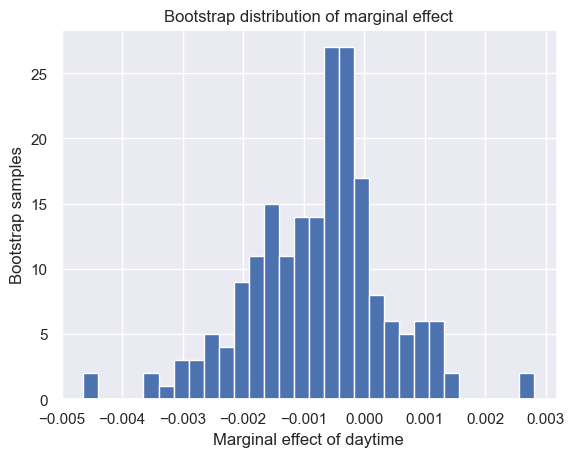

In [28]:
focus_var = 'daytime'
plt.hist(me_boot[focus_var], bins=30)
plt.xlabel(f'Marginal effect of {focus_var}')
plt.ylabel('Bootstrap samples')
plt.title('Bootstrap distribution of marginal effect')


In [29]:
def summarize_bootstrap(df: pd.DataFrame) -> pd.DataFrame:
    mean = df.mean()
    se = df.std(ddof=1)
    return pd.DataFrame({
        'Mean m.e.': mean,
        'Std. err.': se,
        '-1.96 se': mean - 1.96 * se,
        '+1.96 se': mean + 1.96 * se,
    })


In [30]:
bootstrap_summary = summarize_bootstrap(me_boot)


In [31]:
bootstrap_summary.round(4)


,Mean m.e.,Std. err.,-1.96 se,+1.96 se
swhite,-0.0024,0.0024,-0.0071,0.0023
smale,0.0010,0.0009,-0.0007,0.0028
sempl,-0.0025,0.0021,-0.0067,0.0016
sbehavior,0.0205,0.0160,-0.0109,0.0520
omajwhite,0.0002,0.0008,-0.0014,0.0018
daytime,-0.0008,0.0011,-0.0030,0.0015
sage,-0.0001,0.0001,-0.0002,0.0001
sincome,-0.0002,0.0006,-0.0014,0.0011
spop,0.0005,0.0005,-0.0004,0.0014
inctype_lin,-0.0042,0.0027,-0.0095,0.0011


In [32]:
comparison = pd.DataFrame({
    'Delta-method': me_tab['Effect (Logit)'],
    'Bootstrap mean': bootstrap_summary['Mean m.e.'],
    'Bootstrap s.e.': bootstrap_summary['Std. err.'],
})
comparison.round(4)


,Delta-method,Bootstrap mean,Bootstrap s.e.
swhite,-0.0022,-0.0024,0.0024
smale,0.0011,0.0010,0.0009
sempl,-0.0027,-0.0025,0.0021
sbehavior,0.0192,0.0205,0.0160
omajwhite,0.0002,0.0002,0.0008
daytime,-0.0010,-0.0008,0.0011
sage,-0.0001,-0.0001,0.0001
sincome,-0.0001,-0.0002,0.0006
spop,0.0007,0.0005,0.0005
inctype_lin,-0.0044,-0.0042,0.0027


In [33]:
me_boot.describe().T.round(4)


,count,mean,std,min,25%,50%,75%,max
swhite,200.0,-0.0024,0.0024,-0.0130,-0.0033,-0.0019,-0.0006,0.0017
smale,200.0,0.0010,0.0009,-0.0004,0.0004,0.0008,0.0014,0.0044
sempl,200.0,-0.0025,0.0021,-0.0137,-0.0035,-0.0022,-0.0012,0.0014
sbehavior,200.0,0.0205,0.0160,0.0007,0.0093,0.0159,0.0265,0.0862
omajwhite,200.0,0.0002,0.0008,-0.0029,-0.0002,0.0001,0.0005,0.0038
daytime,200.0,-0.0008,0.0011,-0.0046,-0.0015,-0.0006,-0.0002,0.0028
sage,200.0,-0.0001,0.0001,-0.0005,-0.0001,-0.0001,-0.0000,-0.0000
sincome,200.0,-0.0002,0.0006,-0.0034,-0.0004,-0.0000,0.0002,0.0014
spop,200.0,0.0005,0.0005,-0.0011,0.0002,0.0004,0.0008,0.0019
inctype_lin,200.0,-0.0042,0.0027,-0.0137,-0.0057,-0.0036,-0.0022,-0.0001
